In [460]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#### Some Notes on Pymongo
General Code:
> from pymongo import MongoClient('localhost', port)  
> client = MongoClient() # Init on default host and port  

Ideas:  
- read JSON or txt into database (may need list style)
- Cursor over entries
- I dont think rewind is necessary if loop through db.find()


'''

In [272]:
# Export is some file info, authority has program ID's (drop NAN enacted)
# Implementing Sector has ID for Authority Level (state, county)
# Parameter Set: Parameter Set Id (Links to parameter), 
pgm = pd.read_csv('Data/dsir/program.csv')
state = pd.read_csv('Data/dsir/state.csv')
pgm_tech = pd.read_csv('Data/dsir/program_technology.csv')
tech = pd.read_csv('Data/dsir/technology.csv')
tech_cat = pd.read_csv('Data/dsir/technology_category.csv')
ener_cat = pd.read_csv('Data/dsir/energy_category.csv')
pgm_util = pd.read_csv('Data/dsir/program_utility.csv')
util = pd.read_csv('Data/dsir/utility.csv')
pgm_cat = pd.read_csv('Data/dsir/program_category.csv')
pgm_type = pd.read_csv('Data/dsir/program_type.csv')
pgm_county = pd.read_csv('Data/dsir/program_county.csv')
county = pd.read_csv('Data/dsir/county.csv')
sector = pd.read_csv('Data/dsir/sector.csv')

In [ ]:
# Program Selection
    # Program: Is_entire_state == 1
    # Program: Additional Technologies == NaN
# Merging
    # Merge pgm_tech on pgm['id'] = pgm_tech['program_id'], get technology_id as subcategory
# Merge Sector Id
# Merge Program Category ID: Incentive, Regulatory
# Merge Program Type: Rebate, Tax Credit
# Include Tech.db Active == 0

Main Ideas  
- What state favors what programs? By Tech_ID

files = [
#'authority.csv',
#'program_detail.csv',
#'city.csv',
#'program_detail_template.csv',
#'contact.csv',
#'program_sector.csv',
#'county.csv',
'''''''program_technology.csv', 
'''''''energy_category.csv', 
'program_type.csv', # rebate, tax credit
#'export.csv',
'program_utility.csv',
#'implementing_sector.csv',
#'program_zipcode.csv',
#'parameter.csv', dont do
'sector.csv',
#'parameter_set.csv', dont do
'''''''state.csv',
#'parameter_set_sector.csv', dont do
'subscription_memo.csv',
#'parameter_set_technology.csv', dont do
'''''''technology.csv',
'program.csv',
'''''''technology_category.csv',
'program_category.csv',
'utility.csv',
'program_city.csv',         
'utility_zipcode.csv',
#'program_contact.csv',
'zipcode.csv',
'program_county.csv'
]

In [64]:
list(pgm.columns)

['id',
 'state_id',
 'is_entire_state',
 'implementing_sector_id',
 'program_category_id',
 'program_type_id',
 'created_by_user_id',
 'code',
 'name',
 'updated_ts',
 'created_ts',
 'published',
 'websiteurl',
 'administrator',
 'fundingsource',
 'budget',
 'start_date',
 'start_date_text',
 'end_date',
 'end_date_text',
 'summary',
 'additional_technologies',
 'fromSir']

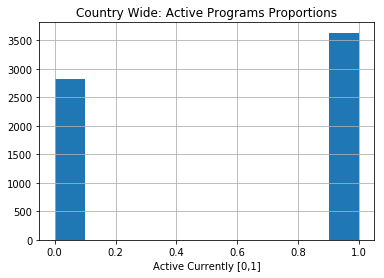

In [124]:
ax1 = pgm['published'].hist()
ax1.set_xlabel('Active Currently [0,1]')
ax1.set_title('Country Wide: Active Programs Proportions')
plt.show()
fig1 = ax1.get_figure()

Looking at Published* stats more closely...

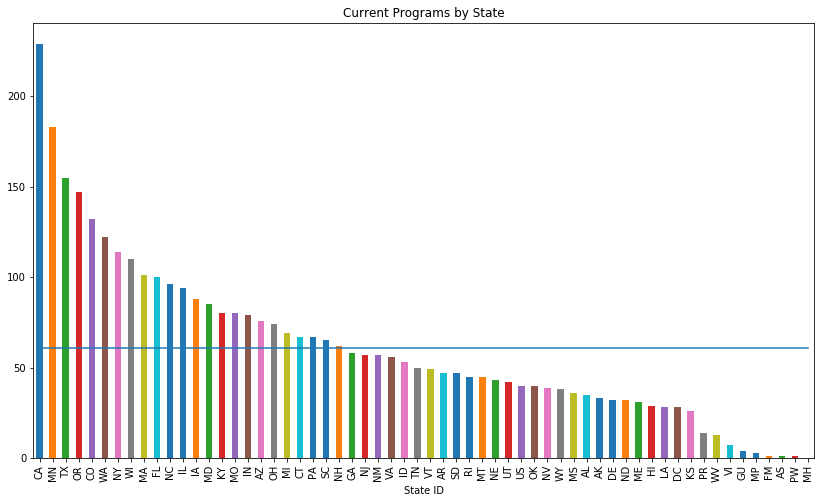

In [176]:
pgm_state_id = pgm.groupby(by = ['state_id'])
ax2 = pgm_state_id['published'].sum().sort_values(ascending=False).plot.bar(figsize = (14, 8))
ax2.set_xlabel('State ID')
ax2.set_title('Current Programs by State')
ax2.plot([pgm_state_id['published'].sum().mean()]*len(pgm_state_id['published']));
fig2 = ax2.get_figure()

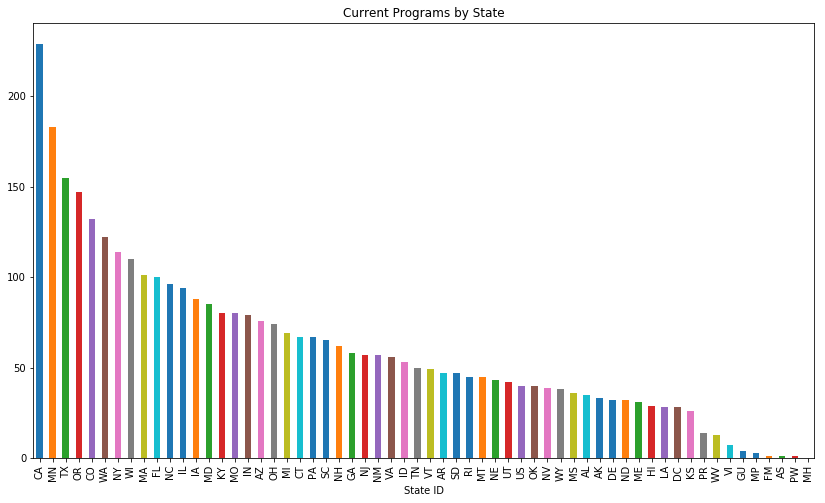

In [191]:
np.array(pgm_state_id['published'].transform(lambda x: 1-x))
fig3, ax3 = plt.subplots()
ax3.bar()
ax3.set_title('Current Programs by State')
fig3 = ax3.get_figure()

In [ ]:
# UPDATE FIGURES
fig1.savefig('pgm_published_hist.png')
fig2.savefig('pgm_by_state.png')

In [320]:
# Tech
outer = tech_cat.merge(ener_cat.set_index('id'), left_on = 'energy_category_id', right_on = 'id', suffixes = ('_tech','_energy'))
outer.drop(columns = 'energy_category_id', inplace = True)
inner = tech.merge(outer.set_index('id'), left_on = 'technology_category_id', right_on = 'id')
inner.drop(columns = 'technology_category_id', inplace = True)
outer = pgm_tech.merge(inner.set_index('id'), left_on = 'technology_id', right_on = 'id')
outer['name_subtech'] = outer['name']
outer.drop(columns = 'name', inplace = True)
df1 = outer.set_index('program_id').join(pgm.set_index('id'), on = 'program_id')
df1.reset_index();

In [321]:
df1.shape

(34679, 27)

In [322]:
# State
state.drop(columns = 'name', inplace = True)
df2 = df1.merge(state.set_index('id'), left_on = 'state_id', right_on = 'id')
df2['state'] = df2['abbreviation']
df2.drop(columns = ['state_id', 'abbreviation'], inplace = True)

In [323]:
df2.shape

(34679, 28)

In [341]:
# Program Type/Category
outer = df2.merge(pgm_type.set_index('id').drop(columns = 'program_category_id'), 
                  left_on = 'program_type_id', right_on = 'id', suffixes = ('_program','_type'))
inner = outer.merge(pgm_cat.set_index('id'), left_on = 'program_category_id',
                    right_on = 'id', suffixes = ('_program','_category'))
inner['name_category'] = inner['name']
df3 = inner.drop(columns = 'name')
# Ignore County
#outer = county.set_index('id').merge(pgm_county, left_on = 'id', right_on = 'county_id').drop(columns = ['state_id','county_id'])
#df3 = inner.merge(outer, left_on = 'id', right_on = 'program_id', suffixes = ('_program','_county'))
#df3['name_county'] = df3['name']
#df3.drop(columns = 'name', inplace = True)

In [345]:
df3.shape

(34679, 30)

In [346]:
to_drop = ['technology_id',
 #'active',
 #'name_tech',
 #'name_energy',
 #'name_subtech',
 #'is_entire_state',
 #'implementing_sector_id',
 'program_category_id',
 'program_type_id',
 'created_by_user_id',
 'code',
 #'name_program',
 'updated_ts',
 'created_ts',
 #'published',
 'websiteurl',
 'administrator',
 'fundingsource',
 #'budget',
 #'start_date',
 #'start_date_text',
 #'end_date',
 #'end_date_text',
 'summary',
 'additional_technologies',
 'fromSir',
 #'is_territory',
 #'state',
 #'name_type',
 #'name_category'
          ]

In [426]:
df4 = df3.drop(columns = to_drop)#, inplace = True)
sec = sector[sector['is_selectable'] == 1][['id','name']]
sec = sec.set_index('id').reset_index()
df5 = df4.merge(sec, left_on = 'implementing_sector_id', right_on = 'id')
df5['name_sector'] = df5['name']
df5.drop(columns = ['start_date_text','end_date_text', 'name'], inplace = True)

In [427]:
df5.shape

(33139, 17)

In [503]:
# Get Date Frame 
date_df = df5
# Get Mask
pubs = df5[['published','start_date','end_date']]
in1 = np.array([1 if (type(pubs.start_date[i]) == str) else 0 for i in range(len(pubs.start_date))])
out1 = np.array([1 if (type(pubs.end_date[i]) == str) else 0 for i in range(len(pubs.end_date))])
useable = np.array((pubs['published']==0) & (in1) & (out1))
pub_useable = np.array((pubs['published']==1) & (in1) & (~out1))
not_date_df = date_df[pub_useable]
# Throw away current programs
date_df = date_df[useable]
dt_start = [datetime.fromisoformat(i) for i in date_df.start_date]
dt_end = [datetime.fromisoformat(i) for i in date_df.end_date]
dt_dlt = [dt_end[i] - dt_start[i] for i in range(len(dt_start))] 
months = [dt_dlt[i].total_seconds()/2.628e6 for i in range(len(dt_dlt))]

In [508]:
date_df['months'] = months
date_df.drop(columns = ['start_date', 'end_date'], inplace = True)

In [510]:
date_df.to_csv('date_df.csv')

In [425]:
df5.columns

Index(['active', 'name_tech', 'name_energy', 'name_subtech', 'is_entire_state',
       'implementing_sector_id', 'name_program', 'published', 'budget',
       'start_date', 'start_date_text', 'end_date', 'end_date_text',
       'is_territory', 'state', 'name_type', 'name_category', 'id',
       'name_sector'],
      dtype='object')

In [429]:
budget = df5[['budget']]

In [446]:
bud = np.array([True if (type(budget.budget[i]) == str) else False for i in range(len(budget.budget))])

In [447]:
sum(bud & pub_useable)

448

In [455]:
dt = pubs.iloc[10003][1]

In [461]:
datetime.fromisoformat(dt)

datetime.datetime(2015, 1, 26, 20, 4)

In [450]:
budget[bud]

,budget
1103,$704.4 million (RPS program expenses through 1...
1104,$704.4 million (RPS program expenses through 1...
1106,$704.4 million (RPS program expenses through 1...
1108,$704.4 million (RPS program expenses through 1...
1110,$704.4 million (RPS program expenses through 1...
1111,$704.4 million (RPS program expenses through 1...
1112,$704.4 million (RPS program expenses through 1...
1114,$704.4 million (RPS program expenses through 1...
1115,$704.4 million (RPS program expenses through 1...
1117,$704.4 million (RPS program expenses through 1...
